# Prediction Interval

* How to exploit prediction interval techniques on regression tasks in CapyMOA
* Two prediction interval learners are implemented in CapyMOA so far

**notebook last updated on 04/05/2024**

In [1]:
from capymoa.datasets import Fried

# load data
fried_stream = Fried()

## 1. Basic prediction interval learner build-up

* an example of the use case of prediction interval in CapyMOA
* current available prediction interval learners require a regressive base learner to work

In [2]:
from capymoa.regressor import SOKNL
from capymoa.prediction_interval import MVE

# build prediction interval learner in regular manner
soknl = SOKNL(schema=fried_stream.get_schema(), ensemble_size=10)
mve = MVE(schema=fried_stream.get_schema(), base_learner=soknl)

# build prediction interval learner in in-line manner
mve_inline = MVE(schema=fried_stream.get_schema(), base_learner=SOKNL(schema=fried_stream.get_schema(), ensemble_size=10))

## 2. Creating evaluators

* we involve two types of prediction interval evaluators so far: basic (cumulative) and windowed.

In [3]:
from capymoa.evaluation.evaluation import PredictionIntervalEvaluator, PredictionIntervalWindowedEvaluator
# build prediction interval (basic and windowed) evaluators
mve_evaluator = PredictionIntervalEvaluator(schema=fried_stream.get_schema())
mve_windowed_evaluator = PredictionIntervalWindowedEvaluator(schema=fried_stream.get_schema(), window_size=1000)

## 3. Running test-then-train/prequential tasks manually

**don't forget to train the mode (call .train() function) at the end!**

In [4]:
# run test-then-train/prequential tasks 
while fried_stream.has_more_instances():
    instance = fried_stream.next_instance()
    prediction = mve.predict(instance)
    mve_evaluator.update(instance.y_value, prediction)
    mve_windowed_evaluator.update(instance.y_value, prediction)
    mve.train(instance)

## 4. Results from both evaluators

In [5]:
# show results
print(f'MVE basic evaluation:\ncoverage: {mve_evaluator.coverage()}, NMPIW: {mve_evaluator.NMPIW()}')
print(f'MVE windowed evaluation in last window:\ncoverage: {mve_windowed_evaluator.coverage()}, NMPIW: {mve_windowed_evaluator.NMPIW()}')

MVE basic evaluation:
coverage: 97.28, NMPIW: 30.66
MVE windowed evaluation in last window:
coverage: 96.8, NMPIW: 32.76


## 5. Wrap things up with prequential evaluation

* prediction interval tasks also can be wrapped up with prequential evaluation in CapyMOA

In [6]:
from capymoa.evaluation import prequential_evaluation
from capymoa.prediction_interval import AdaPI

# restart stream
fried_stream.restart()
# specify regressive model
regressive_learner = SOKNL(schema=fried_stream.get_schema(), ensemble_size=10)
# build prediction interval models
mve_learner = MVE(schema=fried_stream.get_schema(), base_learner=regressive_learner)
adapi_learner = AdaPI(schema=fried_stream.get_schema(), base_learner=regressive_learner, limit=0.001)
# gather results
mve_results = prequential_evaluation(stream=fried_stream, learner=mve_learner, window_size=1000)
adapi_results = prequential_evaluation(stream=fried_stream, learner=adapi_learner, window_size=1000)

# show overall results
print(f"MVE coverage: {mve_results['cumulative'].coverage()}, NMPIW: {mve_results['cumulative'].NMPIW()} \nAdaPI coverage: {adapi_results['cumulative'].coverage()}, NMPIW: {adapi_results['cumulative'].NMPIW()}")

MVE coverage: 97.28, NMPIW: 30.66 
AdaPI coverage: 96.15, NMPIW: 28.53


## 6. Plots are also supported!

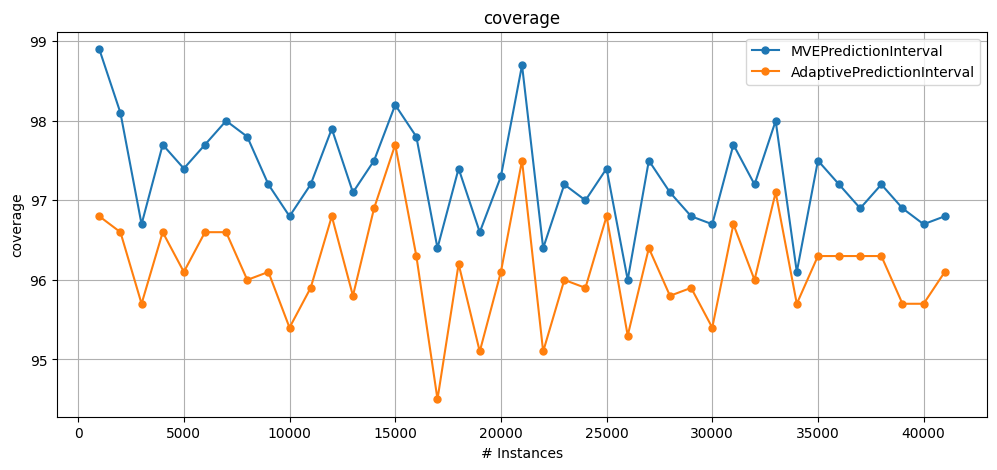

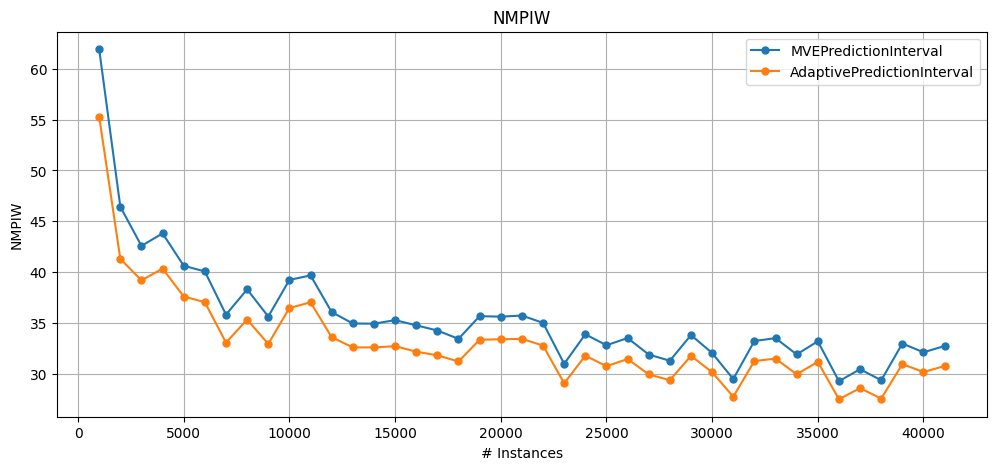

In [8]:
from capymoa.evaluation.visualization import plot_windowed_results
# plot comparison
plot_windowed_results(mve_results,adapi_results, metric='coverage')
plot_windowed_results(mve_results, adapi_results, metric='NMPIW')

### Plot prediction intervals over time

* for comparison, we should also plot multiple intervals from different learners and the ground truths over time
* this part is still under construction...

**Coming soon ;)**